# Clustering Analysis



In [1]:
# importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Loading the final integrated dataset and the scaled dataset

base_df = pd.read_csv('../../Data/preprocessed-data/final_cost_pph_seifa_dataset.csv')
scaled_df = pd.read_csv('../../Data/preprocessed-data/final_scaled_dataset.csv')

In [3]:
# Observing the imported data frames

print(scaled_df.shape, scaled_df.columns.tolist())
print(base_df.shape, base_df.columns.tolist())

(30, 6) ['PHN_Code', 'PHN_Name', 'State', 'Cost_per_person_scaled', 'PPH_rate_per_100k_scaled', 'SEIFA_IRSD_Score_scaled']
(30, 7) ['PHN_Code', 'PHN_Name', 'State', 'PPH_rate_per_100k', 'Cost_per_person', 'SEIFA_IRSD_Score', 'IRSD_Decile_Mean']


In [4]:
# Extracting the required features

scaled_features = scaled_df[['Cost_per_person_scaled','PPH_rate_per_100k_scaled','SEIFA_IRSD_Score_scaled']].to_numpy()
non_scaled_features =  scaled_df[['PHN_Code', 'PHN_Name', 'State']].copy()

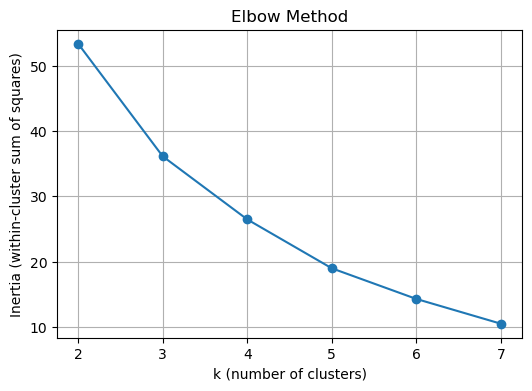

In [5]:
# Finding a proper k value using the elbow method

inertias = []
k_range = range(2,8)

for k in k_range:
    k_mean = KMeans (n_clusters=k, n_init=20, random_state=2333)
    k_mean.fit(scaled_features)
    inertias.append(k_mean.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(k_range), inertias, marker='o')
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

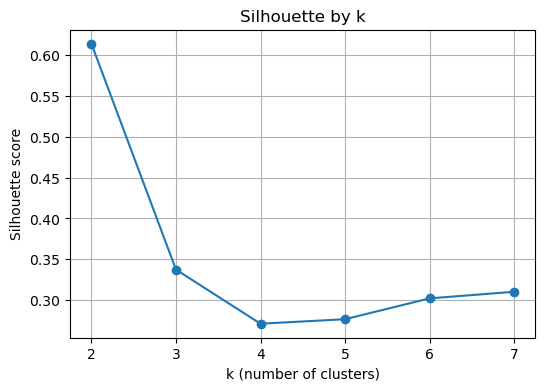

,k,silhouette
0,2,0.614097
1,3,0.337346
2,4,0.271037
3,5,0.276562
4,6,0.302090
5,7,0.310205


In [6]:
# Calculating Silhouette score

sil_scores = []
for k in k_range:
    k_mean = KMeans(n_clusters=k, n_init=20, random_state=2333)
    labels = k_mean.fit_predict(scaled_features)
    sil_score = silhouette_score(scaled_features, labels)
    sil_scores.append(sil_score)

plt.figure(figsize=(6,4))
plt.plot(list(k_range), sil_scores, marker='o')
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette score")
plt.title("Silhouette by k")
plt.grid(True)
plt.show()

pd.DataFrame({"k": list(k_range), "silhouette": sil_scores})


### Choice of Optimal Number of Clusters (k)

Evaluated the optimal number of clusters using both the **Elbow Method** and the **Silhouette Score**:

- **Elbow Method**: Showed a clear "bend" at *k = 4*, indicating that four clusters provide a good balance between reducing within-cluster variance and avoiding overfitting.
- **Silhouette Score**: Suggested *k = 2* as the highest score, but this would oversimplify the dataset into only two broad categories, limiting the ability to capture nuanced regional differences.

Given the project goal to analyze regional disparities in healthcare cost, outcomes, and socio-economic factors across PHNs, **k = 4** was selected.  


In [7]:
# Fitting the final K-Means and attaching labels

optimal_k = 4

k_mean = KMeans(n_clusters=optimal_k, n_init=20, random_state=2333)
labels = k_mean.fit_predict(scaled_features)

clusters_df = non_scaled_features.copy()
clusters_df['Cluster'] = labels

clusters_df.head()

,PHN_Code,PHN_Name,State,Cluster
0,PHN101,Central and Eastern Sydney,NSW,1
1,PHN102,Northern Sydney,NSW,1
2,PHN103,Western Sydney,NSW,3
3,PHN104,Nepean Blue Mountains,NSW,3
4,PHN105,South Western Sydney,NSW,3


In [8]:
# Merging labels (clusters) column to the unscaled base dataset

full_clusteres_df = clusters_df.merge(
    base_df[['PHN_Code','PPH_rate_per_100k', 'Cost_per_person', 'SEIFA_IRSD_Score',]],
    on='PHN_Code', how='left'
)

full_clusteres_df.head()

,PHN_Code,PHN_Name,State,Cluster,PPH_rate_per_100k,Cost_per_person,SEIFA_IRSD_Score
0,PHN101,Central and Eastern Sydney,NSW,1,1688.577,111.426,1033.035
1,PHN102,Northern Sydney,NSW,1,1795.760,111.426,1085.809
2,PHN103,Western Sydney,NSW,3,1616.840,111.426,997.145
3,PHN104,Nepean Blue Mountains,NSW,3,1695.080,111.426,1005.928
4,PHN105,South Western Sydney,NSW,3,1639.889,111.426,931.202


In [9]:
# Saving the full_clusters_df in to csv format
full_clusteres_df.to_csv("../../Data/preprocessed-data/final_clustered_dataset.csv", index=False)

In [12]:
# Profiling the clusters

clustering_profile = (
    full_clusteres_df
    .groupby('Cluster', as_index=False)
    .agg(
        Num_of_PHNs = ('PHN_Code', 'count'),
        Cost_PP_Mean = ('Cost_per_person', 'mean'),
        PPH_Mean = ('PPH_rate_per_100k', 'mean'),
        SEIFA_IRSD_Score_Mean = ('SEIFA_IRSD_Score', 'mean')
    )
    .sort_values('Cluster')
    .round(3)
)
clustering_profile

,Cluster,Num_of_PHNs,Cost_PP_Mean,PPH_Mean,SEIFA_IRSD_Score_Mean
0,0,8,123.753,2345.443,972.037
1,1,8,122.477,1903.340,1041.799
2,2,1,158.075,4152.960,921.922
3,3,13,114.796,1794.631,984.242


In [18]:
# Grouping the clusters according to the states

state_cluster_matrix = full_clusteres_df.groupby(['Cluster','State']).size().unstack(fill_value=0)
state_cluster_matrix


State,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
Cluster,,,,,,,,
0,0,0,0,5,0,1,1,1
1,1,2,0,2,0,0,2,1
2,0,0,1,0,0,0,0,0
3,0,8,0,0,2,0,2,1


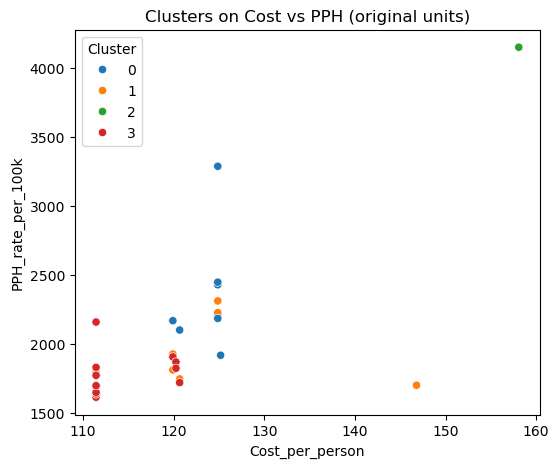

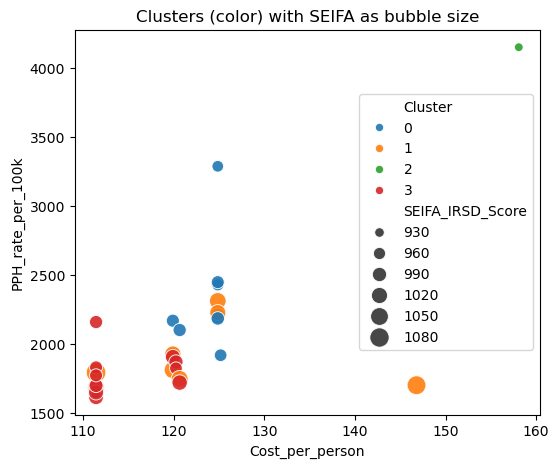

In [21]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=full_clusteres_df,
    x='Cost_per_person', y='PPH_rate_per_100k',
    hue='Cluster', palette='tab10'
)
plt.title("Clusters on Cost vs PPH (original units)")
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=full_clusteres_df,
    x='Cost_per_person', y='PPH_rate_per_100k',
    hue='Cluster', size='SEIFA_IRSD_Score', sizes=(40,200),
    palette='tab10', alpha=0.9
)
plt.title("Clusters (color) with SEIFA as bubble size")
plt.show()


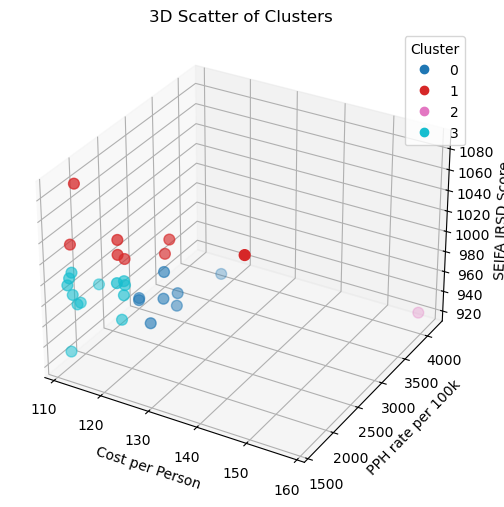

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    full_clusteres_df['Cost_per_person'],
    full_clusteres_df['PPH_rate_per_100k'],
    full_clusteres_df['SEIFA_IRSD_Score'],
    c=full_clusteres_df['Cluster'], cmap='tab10', s=60
)

ax.set_xlabel('Cost per Person')
ax.set_ylabel('PPH rate per 100k')
ax.set_zlabel('SEIFA IRSD Score')
plt.title("3D Scatter of Clusters")
plt.legend(*sc.legend_elements(), title="Cluster")
plt.show()


In [20]:
# Saving the clustering profile and state matrix into csv files

clustering_profile.to_csv("../../Data/preprocessed-data/cluster_profile_summary.csv", index=False)
state_cluster_matrix.to_csv("../../Data/preprocessed-data/cluster_state_matrix.csv")